# Titanic - EDA and feature engineering

In [1]:
import numpy as np
import pandas as pd
from sklearn.impute import KNNImputer
import matplotlib.pyplot as plt

In [2]:
#Read CSV and see general summary information
titanic_df = pd.read_csv("train.csv")
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
titanic_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


From the info we can see that we have twelve available predictors. Most of them have no missing values. "Age" has 714/891 entries. Then, "Cabin" has 204/891 entries. "Embarked" has 2 missing values. If there are a lot of missing values, we may discard that column, otherwise if there are few missing values we will try to impute them.

Next, let us investigate the predictor variables to gain more insight into the dataframe.

General ideas and hypotheses at this point are
- Males have higher death rate. This is because they prioritzed evacuating children and women. 
- The Passenger class might influence survival rate. If you belong to the 1st class, you are richer and may be prioritized during evacuation. 
- Age might reveal some trends. I would assume that young children are more likely to be prioritized during evacuation. In this case probably with their mothers as well. 
- Fare prices may indicate if the person is wealther, again leading to higher survival chance. But this may also indicate just a big family travelling together. 
- There are a lot of missing cabin values. But, I have an idea that maybe only important people had their cabin values in the records. Per now a wild guess, but novel. Where the cabins are placed on the ship might also influence, the survival rate. Maybe some are located closer to lifeboats. 
- There are also different stations. Interesting to see if the port had any bearing on survival. 
- The tickets column, seems meaningless, so will be dropped.
- Name column may initially be dropped. But maybe, they contain titles. This might be indicative of status, and thus may impact survival.

*Survival rate*

In [4]:
titanic_df["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [5]:
titanic_df["Survived"].value_counts()/len(titanic_df)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

The death rate is 61% for the training set. Thus a base model predicting everyone dies has an accuracy of 61%. This is our naive benchmark.

*Passenger class*

In [6]:
titanic_df.groupby("Pclass")[["Survived"]].mean()

,Survived
Pclass,
1,0.629630
2,0.472826
3,0.242363


We see that passengers in the 1st class has the highest survival rate and the 3rd class has lowest survival rate. Thus, Pclass is a good predictor variable to keep in our analysis.

*Gender*

In [7]:
titanic_df.groupby("Sex")[["Survived"]].mean()

,Survived
Sex,
female,0.742038
male,0.188908


Female had much higher survival rate than men. This seems also to be a good predictor.

*Cabin*

We want to do a group by based on if the passenger has a registered cabin or not. This is rudimentary. A more complete analysis may include splitting the cabins, anc checking if the passenger in different decks have different survival rates. 

In [8]:
titanic_df["hasCabin"] = titanic_df["Cabin"].isna()
titanic_df.groupby("hasCabin")[["Survived"]].mean()

,Survived
hasCabin,
False,0.666667
True,0.299854


I don't know how to interpret this. But it seems like passengers having a cabin have lower chance of survival than the passengers who do not. In general the Cabin feature has many missing values, so I may discard this column.

*Age*

<Axes: >

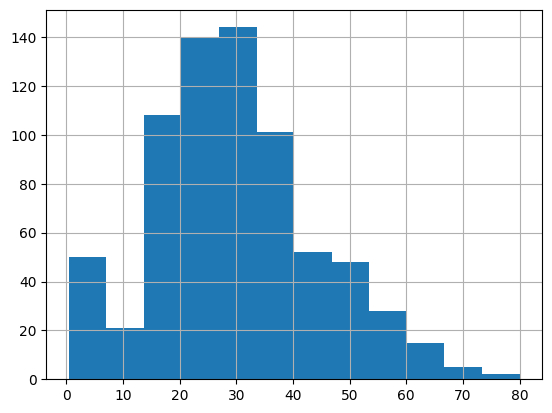

In [9]:
titanic_df["Age"].hist(bins=12)

We plot the ages of the passengers in a histogram. We see that most pasengers are 20-40 years old.

In [10]:
titanic_df["Age"].isna().value_counts()

False    714
True     177
Name: Age, dtype: int64

In [11]:
na_age = titanic_df[titanic_df["Age"].isna()]
na_age["Survived"].mean() #Low percentage of without age survived 0.29
na_age.groupby(["Pclass", "Sex"])[["Survived"]].agg({"mean", "count"})

Survived          
                 count      mean
Pclass Sex                      
1      female        9  1.000000
       male         21  0.238095
2      female        2  1.000000
       male          9  0.222222
3      female       42  0.595238
       male         94  0.095745

If we categorize the passengers with missing age entries, bassed on Pclass and Sex, we see that they have different survival rates. Also the median ages of each of these subcategories are different. Thus we impute the missing values based on pclass and sex and not only the median age of the whole dataset. 

In [12]:
pclass_sex_age = titanic_df.groupby(["Pclass", "Sex"])[["Age"]].median()["Age"]
for index, row in titanic_df.iterrows():
    if np.isnan(row["Age"]):
        pclass = row["Pclass"]
        sex = row["Sex"]
        median_age = pclass_sex_age[pclass][sex]
        titanic_df["Age"][index] = median_age

C:\Users\eier\AppData\Local\Temp\ipykernel_2504\2025922636.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  titanic_df["Age"][index] = median_age


In [13]:
bins = [0,16, 40, 80]
labels = ["Children","Middleage","Elderly"]
titanic_df["AgeGroup"] = pd.cut(titanic_df["Age"], bins=bins, labels=labels, right=True)
titanic_df["AgeGroup"].value_counts()

Middleage    641
Elderly      150
Children     100
Name: AgeGroup, dtype: int64

In [14]:
titanic_df.groupby("AgeGroup")[["Survived"]].mean()

,Survived
AgeGroup,
Children,0.550000
Middleage,0.361934
Elderly,0.366667


We see that children had higher survival rate. The survival rate of middleage and elderly are similar. We may thus only consider two categories, namely children and adult. Thus we combine the age and sex categories into one new feature.

In [15]:
bins = [0,16, 40, 80]
labels = ["Children","Middleage","Elderly"]
age_group = pd.cut(titanic_df["Age"], bins=bins, labels=labels, right=True)
age_group.value_counts()

Middleage    641
Elderly      150
Children     100
Name: Age, dtype: int64

Let us now try to combine "Age" and "Sex" columns

In [16]:
bins = [0,16, 80]
labels = ["child", 0]
child = pd.cut(titanic_df["Age"], bins=bins, labels=labels, right=True)
titanic_df["child_or_gender"] = child
titanic_df["child_or_gender"] = np.where(titanic_df["child_or_gender"] == 0, 
    titanic_df["Sex"], "child"
)
titanic_df["child_or_gender"].value_counts()


male      526
female    265
child     100
Name: child_or_gender, dtype: int64

In [17]:
titanic_df.groupby("child_or_gender")[["Survived"]].mean()

,Survived
child_or_gender,
child,0.550000
female,0.754717
male,0.165399


NB! Changing the age limit for children, might impact the analysis. Per now the threshold is set arbitrarily.

*Embarked*

In [18]:
titanic_df.groupby("Embarked")[["Survived"]].mean()

,Survived
Embarked,
C,0.553571
Q,0.389610
S,0.336957


Ports Qeensland and Southampton yield similar survival rates. Better survival rates from Cherbourg.

In [19]:
titanic_df["Embarked"].isna().sum()

2

We have two missing values.

<Axes: >

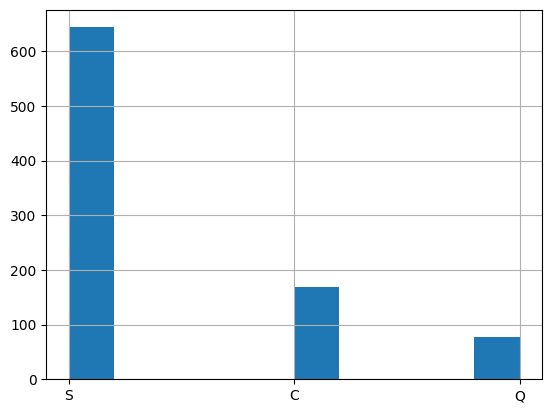

In [20]:
titanic_df["Embarked"].hist()

We see that most passengers boarded at Southampton. So we impute the missing values with this port

In [21]:
titanic_df["Embarked"].fillna("S", inplace=True)

*Parch and Sibsp*

Parch = # of parent children

Sibsp = # of sibling spouse

So these predictors indicate familial relations and almost if people are travelling together or alone.

In [39]:
titanic_df.groupby("Parch")[["Survived"]].agg({"mean", "count"})

Survived          
         count      mean
Parch                   
0          678  0.343658
1          118  0.550847
2           80  0.500000
3            5  0.600000
4            4  0.000000
5            5  0.200000
6            1  0.000000

In [40]:
titanic_df.groupby("SibSp")[["Survived"]].agg({"mean", "count"})

Survived          
         count      mean
SibSp                   
0          608  0.345395
1          209  0.535885
2           28  0.464286
3           16  0.250000
4           18  0.166667
5            5  0.000000
8            7  0.000000

In general for SibSp and Parch values 1-3 give higher survival rates. For values >3 the amount of people in these categories is relatively few. Biggest frequency is 0 for both predictors.

What if we combine these features into one?

In [43]:
titanic_df["Family"] = titanic_df["Parch"] + titanic_df["SibSp"]
titanic_df.groupby("Family")[["Survived"]].agg({"mean", "count"})

Survived          
          count      mean
Family                   
0           537  0.303538
1           161  0.552795
2           102  0.578431
3            29  0.724138
4            15  0.200000
5            22  0.136364
6            12  0.333333
7             6  0.000000
10            7  0.000000

We groupby the counts 1-2-3 together and the other ones together.

In [28]:
titanic_df["FamilySize"] = np.where((0<titanic_df["Family"]) & (titanic_df["Family"]<4), 
    "Family", "No/Big"
)
titanic_df.groupby("FamilySize")[["Survived"]].agg({"mean", "count"})

Survived          
              count      mean
FamilySize                   
Family          292  0.578767
No/Big          599  0.288815

*Fare*

<Axes: >

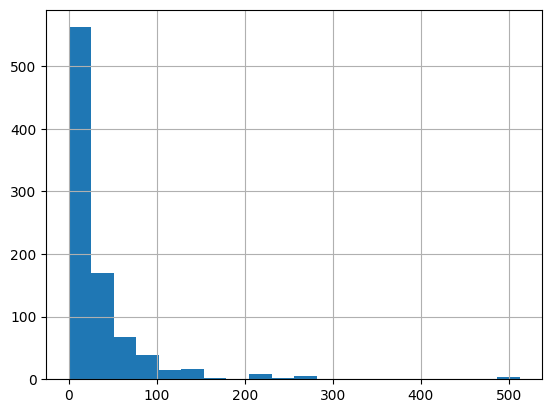

In [29]:
titanic_df["Fare"].hist(bins=20)

In [30]:
titanic_df.groupby("Fare")[["Survived"]].agg({"mean", "count"})

Survived          
            count      mean
Fare                       
0.0000         15  0.066667
4.0125          1  0.000000
5.0000          1  0.000000
6.2375          1  0.000000
6.4375          1  0.000000
...           ...       ...
227.5250        4  0.750000
247.5208        2  0.500000
262.3750        2  1.000000
263.0000        4  0.500000
512.3292        3  1.000000

[248 rows x 2 columns]

We see that there are 248 different fare prices. We might induce from a quick glance at the summary that people with low fares have lower survival rate, than those that pay a bigger buck.

In [31]:
titanic_df["Fare"].median()

14.4542

We computed the mean fare which is 14.45. The mean would be higher as influence by the highest fares. 

In [32]:
titanic_df["FarePriceCategory"] = np.where(titanic_df["Fare"]< 11, "Cheap", "Expensive")
titanic_df.groupby("FarePriceCategory")[["Survived"]].agg({"mean", "count"})

Survived          
                     count      mean
FarePriceCategory                   
Cheap                  364  0.208791
Expensive              527  0.504744

In [33]:
titanic_df[titanic_df["Fare"]>80]["Survived"].mean()

0.7702702702702703

After examining the high prices and the low prices. I am inclined to create more categories. I want one with the lowest fare prices. Then one with the higher fare prices and lastly, the inbetween category.

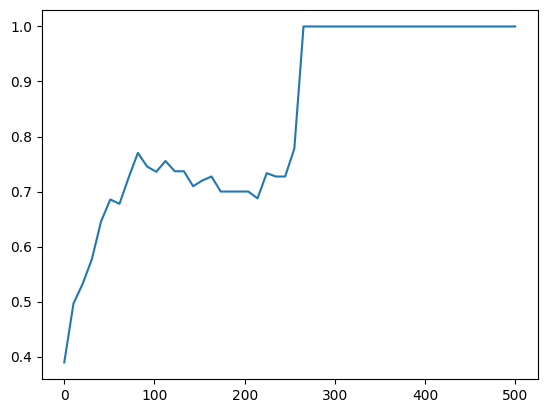

In [34]:
fares = np.linspace(0,500, 50)
survival_rates = [titanic_df[titanic_df["Fare"]>fare]["Survived"].mean() for fare in fares]
plt.plot(fares, survival_rates)
plt.show()

In [35]:
survival_rates[8], fares[8]

(0.7702702702702703, 81.63265306122449)

In [36]:
bins = [0,11, 80,500]
labels = ["Cheapest","Average","Expensive"]
fare_groups = pd.cut(titanic_df["Fare"], bins=bins, labels=labels, right=True)
titanic_df["FareGroups"] = fare_groups

In [37]:
titanic_df.groupby("FareGroups")[["Survived"]].agg({"mean", "count"})

Survived          
              count      mean
FareGroups                   
Cheapest        349  0.214900
Average         453  0.461369
Expensive        71  0.760563

The Category in the middle is neither here nor there. But we have isolated the cheapest and most expensive fares. 

*Features*

In [38]:
titanic_df.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'hasCabin', 'AgeGroup',
       'child_or_gender', 'Family', 'FamilySize', 'FarePriceCategory',
       'FareGroups'],
      dtype='object')

Out of these features the main features which are natural to use in building a model are
- Pclass
- Embarked
- child_or_gender
- FamilySize
- FareGroups

We have not analyzed the names and ticket columns for any patterns. One might also do a more thorough analysis of the cabin features. This might be done later on.